# Vehicle Type Classification with **Random Forest**

In [4]:
import pandas as pd

# Load the dataset
file_path = "/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RoadTrafficNoise/IDMT-Traffic/datasets/df_main_encoded_only.csv"

# Load the dataset
df_vehicle_classification = pd.read_csv(file_path)

# Display the first few rows
print(df_vehicle_classification.head())

# Check column names and data types
print(df_vehicle_classification.info())

   Unnamed: 0                                               file  \
0          18  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
1          19  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
2          20  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
3          21  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
4          24  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1141442...   

   is_background_encoded  date_time_encoded  location_encoded  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   

   speed_kmh_encoded  daytime_encoded  weather_encoded  vehicle_encoded  \
0                  0                1                0                1   
1                  0                1             

### without using class weights

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features (X) and target (y)
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74        21
           1       0.90      1.00      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.80      0.21      0.34       205

    accuracy                           0.91      1873
   macro avg       0.91      0.70      0.76      1873
weighted avg       0.90      0.91      0.88      1873



### with using class weights

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features (X) and target (y)
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.90      1.00      0.94      1561
           2       1.00      0.99      0.99        86
           3       0.83      0.17      0.28       205

    accuracy                           0.90      1873
   macro avg       0.89      0.67      0.72      1873
weighted avg       0.89      0.90      0.87      1873



In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for SMOTE ratio
param_grid = {
'smote__sampling_strategy': [{0: 200, 3: ratio} for ratio in [1000, 1200, 1500]]  # Oversample class 0 to 200 and vary class 3
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score (Training): {grid_search.best_score_:.4f}")

# Evaluate the final model on the original test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("\nFinal Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........smote__sampling_strategy={0: 200, 3: 1000}; total time=   6.3s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1000}; total time=   6.3s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1200}; total time=   6.3s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1200}; total time=   6.4s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1200}; total time=   6.4s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1000}; total time=   6.4s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1500}; total time=   6.5s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1500}; total time=   6.5s
[CV] END .........smote__sampling_strategy={0: 200, 3: 1500}; total time=   3.7s
Best Parameters: {'smote__sampling_strategy': {0: 200, 3: 1200}}
Best F1 Score (Training): 0.8919

Final Model Performance on Test Set:
Accuracy: 0.9087026161238655

Classification Report:
              precision

Something is wrong with the data for class 3. I don't know what, but I will drop the class and try again:

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Remove class 3 from the dataset
X = X[y != 3]
y = y[y != 3]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter grid for SMOTE ratio for class 0
param_grid = {
    'smote__sampling_strategy': [{0: ratio} for ratio in [100, 150, 200]]  # Oversample class 0 with different ratios
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score (Training): {grid_search.best_score_:.4f}")

# Evaluate the final model on the original test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("\nFinal Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..................smote__sampling_strategy={0: 150}; total time=   3.7s
[CV] END ..................smote__sampling_strategy={0: 100}; total time=   3.9s
[CV] END ..................smote__sampling_strategy={0: 100}; total time=   3.9s
[CV] END ..................smote__sampling_strategy={0: 200}; total time=   3.8s
[CV] END ..................smote__sampling_strategy={0: 100}; total time=   3.9s
[CV] END ..................smote__sampling_strategy={0: 150}; total time=   3.9s
[CV] END ..................smote__sampling_strategy={0: 200}; total time=   3.9s
[CV] END ..................smote__sampling_strategy={0: 150}; total time=   4.0s
[CV] END ..................smote__sampling_strategy={0: 200}; total time=   2.1s
Best Parameters: {'smote__sampling_strategy': {0: 200}}
Best F1 Score (Training): 0.9941

Final Model Performance on Test Set:
Accuracy: 0.9958033573141487

Classification Report:
              precision    recal

Insights:
1. Class 0 Improvements:
	- Oversampling class 0 successfully improved its recall and overall F1-score without overfitting or degrading the model’s performance for other classes.
	- The best ratio {0: 200} balanced minority class performance and overall model stability.
2.	Perfect Scores for Other Classes:
	- Classes 1 and 2 maintained their nearly perfect performance, which aligns with their relatively high representation in the dataset.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming your dataset is named df and is already loaded
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a RandomForest model on all features to determine importance
rf_full = RandomForestClassifier(random_state=42, n_estimators=100)
rf_full.fit(X_train, y_train)

# Get feature importances
importances = rf_full.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

# Select the top N important features
N = 10  # Adjust as needed
top_features = features[sorted_indices[:N]]

print(f"Top {N} features: {list(top_features)}")

# Create a new dataset with only the top N features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a new RandomForest model on the reduced feature set
rf_top = RandomForestClassifier(random_state=42, n_estimators=100)
rf_top.fit(X_train_top, y_train)

# Evaluate both models
y_pred_full = rf_full.predict(X_test)
y_pred_top = rf_top.predict(X_test_top)

print("Performance with all features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_full):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_full))

print("\nPerformance with top features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_top):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_top))

Top 10 features: ['date_time_encoded', 'speed_kmh_encoded', 'mfcc_3', 'band_19_dB', 'mfcc_9', 'band_18_dB', 'band_3_dB', 'band_4_dB', 'mfcc_5', 'mfcc_4']
Performance with all features:
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74        21
           1       0.90      1.00      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.80      0.21      0.34       205

    accuracy                           0.91      1873
   macro avg       0.91      0.70      0.76      1873
weighted avg       0.90      0.91      0.88      1873


Performance with top features:
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        21
           1       0.91      0.99      0.95      1561
           2       1.00      0.98      0.99        86
           3       0.69      0.25      0.37       205

The model using all features performs better, especially for minority classes. The slight drop in accuracy when using the top 10 features suggests that some excluded features may provide subtle yet meaningful contributions, particularly for the less represented classes. Therefore we keep all features and try hyperparameter optimization instead:

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Define features (X) and target (y)
X = df_vehicle_classification.drop(columns=["file", "is_background_encoded", "vehicle_encoded", "Unnamed: 0"])
y = df_vehicle_classification["vehicle_encoded"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform a grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],       # 2 options
    'max_depth': [None, 10, 20],      # 3 options
    'min_samples_split': [2, 5],      # 2 options
    'min_samples_leaf': [1, 2],       # 2 options
    'max_features': ['sqrt'],         # 1 option
    'bootstrap': [True, False]        # 2 options
}
# 2 * 3 * 2 * 2 * 1 * 2 = 48 total combinations

# Initialize model
rf_clf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=3, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Time the grid search to confirm it stays under ~10 minutes
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Calculate elapsed time
elapsed = end_time - start_time
print(f"\nTime for Grid Search: {elapsed:.2f} seconds (~{elapsed/60:.1f} minutes)")

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (Training):", grid_search.best_score_)

# Train a final model with the best params
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print("\nFinal Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimat

No Substantial Improvement:
- The grid search did not result in a significant improvement over the default model. This is likely because Random Forest models are inherently robust, and the default settings already performed well.

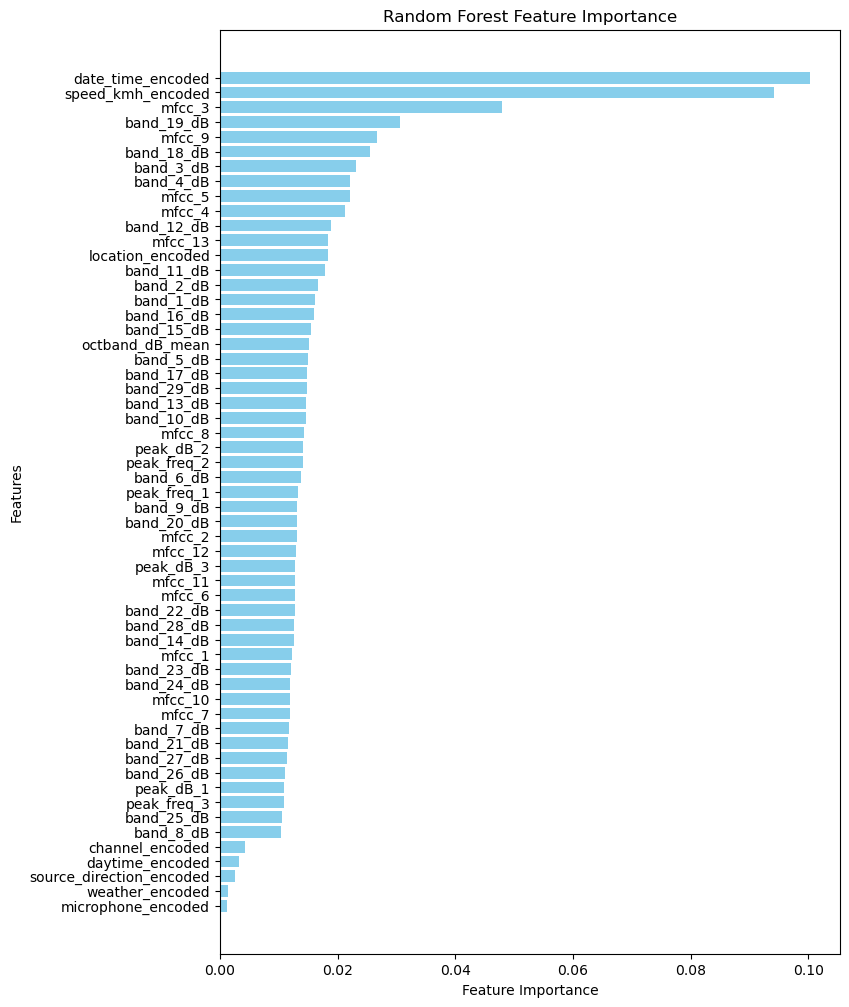

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importances = rf_clf.feature_importances_
features = X.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importance
plt.figure(figsize=(8, 12))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Drop low-importance features if needed
# low_importance_threshold = 0.01  # Set a threshold for feature importance
# low_importance_features = sorted_features[sorted_importances < low_importance_threshold]
# print(f"Low importance features (importance < {low_importance_threshold}): {low_importance_features}")